## Anomaly Detection 

Build small machine learning model to detect anomalous log entries. The anomaly detection system will use Cisco Adaptive Security Appliance (ASA) log files. 
We will use a small training set (training.txt) so we can do a bit of supervised learning and create a small model that can detect anomalies against log files. 
Sample data set (sample.log) has a small anomaly inside it and we will try to find said anomaly. 

![Screenshot 2024-03-29 at 2.16.59 PM.png](<attachment:Screenshot 2024-03-29 at 2.16.59 PM.png>)
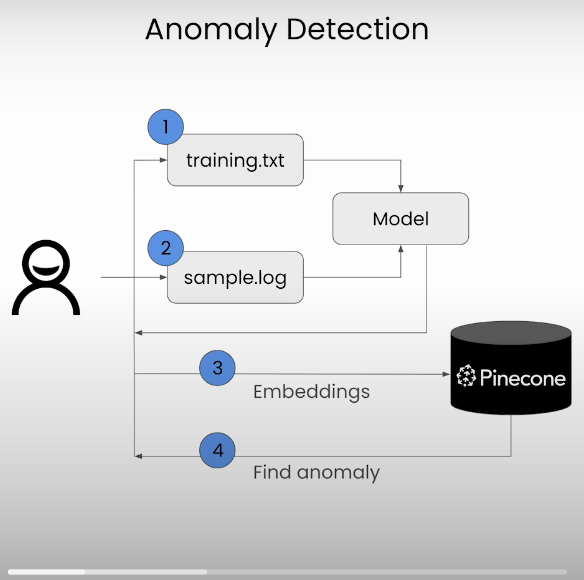

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer, InputExample, losses, models, util
from torch.utils.data import DataLoader
from torch import nn
from tqdm.auto import tqdm
from DLAIUtils import Utils
import torch
import time
import torch
import os

## Setup Pinecone 

In [5]:
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

In [6]:
INDEX_NAME = utils.create_dlai_index_name('dl-ai')

pinecone = Pinecone(api_key=PINECONE_API_KEY)

if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(name=INDEX_NAME, dimension=256, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-west-2'))
index = pinecone.Index(INDEX_NAME)

## Load the Dataset 

In [7]:
#! tar -xzvf ../public/data/training.tar.zip

#! tar -xzvf lesson6.tar

x lesson6.tar
x sample.log
x training.txt


In [8]:
! head -5 sample.log

Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 by access-group "acl_dmz" [0xe3aab522, 0x0]
Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 type 3, code 0, by access-group "acl_dmz" [0xe3aab522, 0x0]
Apr 15 2014 09:34:34 EDT: %ASA-session-5-106100: access-list acl_in permitted tcp inside/10.1.2.16(2241) -> outside/192.0.0.89(2000) hit-cnt 1 first hit [0x71a87d94, 0x0]
Apr 24 2013 16:00:28 INT-FW01 : %ASA-6-106100: access-list inside denied udp inside/172.29.2.101(1039) -> outside/192.0.2.10(53) hit-cnt 1 first hit [0xd820e56a, 0x0]
Apr 24 2013 16:00:27 INT-FW01 : %ASA-6-106100: access-list inside permitted udp inside/172.29.2.3(1065) -> outside/192.0.2.57(53) hit-cnt 144 300-second interval [0xe982c7a4, 0x0]


In [9]:
! head -5 training.txt

Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 by access-group "acl_dmz" [0xe3aab522, 0x0] ^ Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 by access-group "acl_dmz" [0xe3aab522, 0x0] ^ 1.0
Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 type 3, code 0, by access-group "acl_dmz" [0xe3aab522, 0x0] ^ Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 by access-group "acl_dmz" [0xe3aab522, 0x0] ^ 0.9
Apr 15 2014 09:34:34 EDT: %ASA-session-5-106100: access-list acl_in permitted tcp inside/10.1.2.16(2241) -> outside/192.0.0.89(2000) hit-cnt 1 first hit [0x71a87d94, 0x0] ^ Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 by access-group "acl_dmz" [0xe3aab522, 0x0] ^ 0.8
Apr 24 2013 16:00:28 INT-FW01 : %ASA-6-106100: access-list inside denied udp inside/172.29.2.1

## Check cuda and Setup the Model

We are using bert-base-uncased sentence-transformers model that maps sentences to a 256 dimensional dense vector space.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=768)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model], device=device)
device

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

'cpu'

## Train Model

In [11]:
train_examples = []
with open('./training.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        if line:
            a, b, label = line.split('^')
            train_examples.append(InputExample(texts=[a, b], label=float(label)))

#Define dataset, the dataloader and the training loss
warmup_steps=100
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

(Note: load_pretrained_model = True): We've saved the trained model and are loading it here for speedier results, allowing you to observe the outcomes faster. Once you've done an initial run, you may set load_pretrained_model to False to train the model yourself. This can take some time to finsih, depending the value you set for the epochs.

In the context of training a machine learning model, an epoch refers to one complete pass through the entire training dataset. During an epoch, the model will see every sample in the dataset once, which allows the model to learn from the entire data set.
During each epoch, the model tries to learn patterns in the data, adjusting its internal parameters (weights) based on the loss function (which measures the difference between the model's predictions and the actual target values).

In [13]:
import pickle
load_pretrained_model = True
if load_pretrained_model:
    trained_model_file = open('../public/data/pretrained_model', 'rb')    
    db = pickle.load(trained_model_file)
    trained_model_file.close()
else:
    model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=16, warmup_steps=100)

samples = []
with open('sample.log', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        if line:
            #emb = model.encode([line])
            samples.append(line)

## Create Embeddings and Upsert to Pinecone 

In [14]:
emb = model.encode(samples)

In [15]:
prepped = []
for i in tqdm(range(len(samples))):
  v = {'id':f'{i}', 'values':emb[i].tolist(), 'metadata':{'log':samples[i]}}
  prepped.append(v)
index.upsert(prepped)

  0%|          | 0/90 [00:00<?, ?it/s]

{'upserted_count': 90}

## FInd the anomaly

In [16]:
good_log_line = samples[0]

In [17]:
print(good_log_line)

Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 by access-group "acl_dmz" [0xe3aab522, 0x0]


In [18]:
results = []
while len(results)==0:  # After the upserts, it might take a few seconds for index to be ready for query.  
    time.sleep(2)       # If results is empty we try again two seconds later.
    queried = index.query(
        vector=emb[0].tolist(),
        include_metadata=True,
        top_k=100
    )
    results = queried['matches']
    print(".:. ",end="")

.:. 

In [19]:
for i in range(0,10) :
  print(f"{round(results[i]['score'], 4)}\t{results[i]['metadata']['log']}")

1.0	Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 by access-group "acl_dmz" [0xe3aab522, 0x0]
0.9955	Apr 15 2013 09:36:50: %ASA-4-106023: Deny tcp src dmz:10.1.2.30/63016 dst outside:192.0.0.8/53 type 3, code 0, by access-group "acl_dmz" [0xe3aab522, 0x0]
0.9815	Apr 30 2013 09:23:40: %ASA-4-106023: Deny tcp src outside:192.0.2.126/53638 dst inside:10.0.0.132/8111 by access-group "acl_out" [0x71761f18, 0x0]
0.9809	Apr 30 2013 09:23:41: %ASA-4-106023: Deny tcp src outside:192.0.2.126/53638 dst inside:10.0.0.132/8111 by access-group "acl_out" [0x71761f18, 0x0]
0.9804	Dec 11 2018 08:01:39 <IP>: %ASA-4-106023: Deny udp src dmz:192.168.1.34/5679 dst outside:192.0.0.12/5000 by access-group "dmz" [0x123a465e, 0x8c20f21]
0.9795	Sep 12 2014 06:53:01 GIFRCHN01 : %ASA-4-106023: Deny tcp src outside:192.0.2.95/24069 dst inside:10.32.112.125/25 by access-group "PERMIT_IN" [0x0, 0x0]"
0.9764	Dec 11 2018 08:01:24 <IP>: %ASA-4-106023: Deny udp src dmz:19

In [20]:
last_element = len(results) -1 

In [21]:
# This is the worst performing score that came back from Pinecone from the good log line
print(f"{round(results[last_element]['score'], 4)}\t{results[last_element]['metadata']['log']}")

0.8155	dec 31, 2021 09:18:59: %ASA-4-434005: seg fault detected in the matrix
